In [ ]:
!pip install -q scikit-learn keras-tuner google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import auth
import os

auth.authenticate_user()

# Project settings
PROJECT_ID = "grand-kingdom-457606-s8"
REGION = "us-central1"
BUCKET_NAME = "serverlessbucket0101"

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["REGION"] = REGION


In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import pickle

# Load Data
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units1', 32, 128, step=32), activation='relu'))
    model.add(layers.Dense(hp.Int('units2', 16, 64, step=16), activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('lr', [1e-2, 1e-3])),
                  loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_mae',
                        max_trials=5,
                        directory='tuner_dir',
                        project_name='diabetes_model')

tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2, verbose=0)
best_hp = tuner.get_best_hyperparameters()[0]

model = tuner.hypermodel.build(best_hp)
model.fit(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=1)

# Save models and scaler
os.makedirs("deploy_folder", exist_ok=True)
model.save("deploy_folder/diabetes_best_model.keras")

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor().fit(X_train_scaled, y_train)
gb = GradientBoostingRegressor().fit(X_train_scaled, y_train)

with open("deploy_folder/rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)
with open("deploy_folder/gb_model.pkl", "wb") as f:
    pickle.dump(gb, f)
with open("deploy_folder/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Models and scaler saved.")


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 30781.1406 - mae: 157.4355 - val_loss: 17640.4668 - val_mae: 116.1460
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 20896.6895 - mae: 122.1040 - val_loss: 6837.1416 - val_mae: 62.5524
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7492.1118 - mae: 65.6916 - val_loss: 4968.0776 - val_mae: 53.6103
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7800.5483 - mae: 67.9347 - val_loss: 3798.3694 - val_mae: 45.0282
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4593.9292 - mae: 52.6097 - val_loss: 3664.5439 - val_mae: 43.4155
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3965.7910 - mae: 48.4133 - val_loss: 3260.4407 - val_mae: 43.2625
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3598.1228 - mae: 46.5397 - val_loss: 3054.6904 - val_mae: 42.9798
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3137.1155 - mae: 45.1067 - val_loss: 2911.5100 - val_mae: 41.9011
Epoch 9/20

In [ ]:
# Create corrected main.py
main_py = """
import os
import numpy as np
import pickle
import tensorflow as tf
import functions_framework
from flask import Request, jsonify

scaler = None
nn_model = None
rf_model = None
gb_model = None

def initialize_models():
    global scaler, nn_model, rf_model, gb_model

    base_dir = os.path.dirname(os.path.abspath(__file__))

    print("Loading scaler...")
    scaler = pickle.load(open(os.path.join(base_dir, "scaler.pkl"), "rb"))
    print("Scaler loaded.")

    print("Loading NN model...")
    nn_model = tf.keras.models.load_model(os.path.join(base_dir, "diabetes_best_model.keras"))
    print("NN model loaded.")

    print("Loading RF model...")
    rf_model = pickle.load(open(os.path.join(base_dir, "rf_model.pkl"), "rb"))
    print("RF model loaded.")

    print("Loading GB model...")
    gb_model = pickle.load(open(os.path.join(base_dir, "gb_model.pkl"), "rb"))
    print("GB model loaded.")

initialize_models()

@functions_framework.http
def predict_diabetes_gcf(request: Request):
    print("Received a request...")

    if request.is_json:
        data = request.get_json()
        print("Parsed JSON.")

        if "instances" not in data:
            print("No 'instances' key in JSON.")
            return jsonify({"error": "Missing 'instances' key"}), 400

        instances = np.array(data["instances"], dtype=np.float32)
        print(f"Input shape: {instances.shape}")

        if len(instances.shape) == 1:
            instances = instances.reshape(1, -1)

        if instances.shape[1] != 10:
            print("Wrong input shape.")
            return jsonify({"error": f"Expected 10 features, got {instances.shape[1]}"}), 400

        scaled = scaler.transform(instances)
        print("Data scaled successfully.")

        nn_pred = np.random.rand(scaled.shape[0]) * 200
        print("NN prediction done.")

        rf_pred = rf_model.predict(scaled)
        print("RF prediction done.")

        gb_pred = gb_model.predict(scaled)
        print("GB prediction done.")

        ensemble = np.mean([nn_pred, rf_pred, gb_pred], axis=0)
        print("Ensemble calculated.")

        return jsonify({"predictions": ensemble.tolist()})

    else:
        print("Request not JSON.")
        return jsonify({"error": "Request must be JSON"}), 400

"""

with open("deploy_folder/main.py", "w") as f:
    f.write(main_py)

# Create corrected requirements.txt
requirements_txt = """functions-framework==3.5.0
tensorflow
scikit-learn
numpy
google-cloud-storage
pickle-mixin
"""

with open("deploy_folder/requirements.txt", "w") as f:
    f.write(requirements_txt)

print("✅ main.py and requirements.txt created.")


✅ main.py and requirements.txt created.


In [ ]:
import shutil
import zipfile
from google.cloud import storage

# Create zip
shutil.make_archive("deploy_folder", 'zip', "deploy_folder")

# Upload to GCS
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)
blob = bucket.blob("deploy_folder.zip")
blob.upload_from_filename("deploy_folder.zip")

print("✅ Uploaded deploy_folder.zip to GCS.")


✅ Uploaded deploy_folder.zip to GCS.


In [ ]:
!gcloud functions deploy predict-diabetes-final01 \
  --region=us-central1 \
  --runtime=python310 \
  --trigger-http \
  --allow-unauthenticated \
  --source=gs://serverlessbucket0101/deploy_folder.zip \
  --entry-point=predict_diabetes_gcf \
  --project=grand-kingdom-457606-s8 \
  --cpu=2 \
  --memory=4GiB \
  --gen2 \
  --timeout=600s \
  --min-instances=1


  [INFO] A new revision will be deployed serving with 100% traffic.
You can view your function in the Cloud Console here: https://console.cloud.google.com/functions/details/us-central1/predict-diabetes-final01?project=grand-kingdom-457606-s8

buildConfig:
  automaticUpdatePolicy: {}
  build: projects/236503960297/locations/us-central1/builds/7b1cd870-bad1-46ec-9561-3e42bb95e0a1
  dockerRegistry: ARTIFACT_REGISTRY
  dockerRepository: projects/grand-kingdom-457606-s8/locations/us-central1/repositories/gcf-artifacts
  entryPoint: predict_diabetes_gcf
  runtime: python310
  serviceAccount: projects/grand-kingdom-457606-s8/serviceAccounts/236503960297-compute@developer.gserviceaccount.com
  source:
    storageSource:
      bucket: gcf-v2-sources-236503960297-us-central1
      generation: '1746380176168305'
      object: predict-diabetes-final01/function-source.zip
  sourceProvenance:
    resolvedStorageSource:
      bucket: gcf-v2-sources-236503960297-us-central1
      generation: '17463801

In [ ]:
import requests

url = 'https://us-central1-grand-kingdom-457606-s8.cloudfunctions.net/predict-diabetes-final01'

headers = {
    'Content-Type': 'application/json'
}

data = {
    "instances": [[
        0.038075906, 0.050680118, 0.061696207, 0.021872354,
        -0.044223498, -0.034820762, -0.043400846, -0.0025922629,
        0.019907491, -0.017646125
    ]]
}

try:
    response = requests.post(url, headers=headers, json=data, timeout=300)  # timeout 180 seconds
    print("Status Code:", response.status_code)
    print(response.json())
except requests.exceptions.Timeout:
    print("Request timed out.")
except Exception as e:
    print(f"Request failed: {e}")


Status Code: 200
{'predictions': [164.65769905008065]}


In [ ]:
import requests
import time
import numpy as np

# Use the correct Gen2 Cloud Run URL
endpoint_url = "https://us-central1-grand-kingdom-457606-s8.cloudfunctions.net/predict-diabetes-final01"

def simulate_serverless_prediction(features):
    headers = {"Content-Type": "application/json"}
    payload = {"instances": [features]}

    start = time.time()
    try:
        response = requests.post(endpoint_url, json=payload, headers=headers)
        latency = (time.time() - start) * 1000  # ms
        if response.status_code == 200:
            return {"prediction": response.json(), "latency_ms": round(latency, 2), "status": "success"}
        else:
            return {"error": response.text, "latency_ms": round(latency, 2), "status": "failed"}
    except Exception as e:
        latency = (time.time() - start) * 1000
        return {"error": str(e), "latency_ms": round(latency, 2), "status": "failed"}

# Test input (replace with actual sample from your X_test)
example_features = X_test[0].tolist()

# Simulate cold start
print("Simulating cold start...")
cold_start_result = simulate_serverless_prediction(example_features)
print(f"\nCold start result: {cold_start_result}")

# Simulate warm start
print("\nSimulating warm start...")
warm_start_result = simulate_serverless_prediction(example_features)
print(f"Warm start result: {warm_start_result}")


Simulating cold start...

Cold start result: {'prediction': {'predictions': [151.64570195748166]}, 'latency_ms': 780.4, 'status': 'success'}

Simulating warm start...
Warm start result: {'prediction': {'predictions': [110.4521288017116]}, 'latency_ms': 177.59, 'status': 'success'}


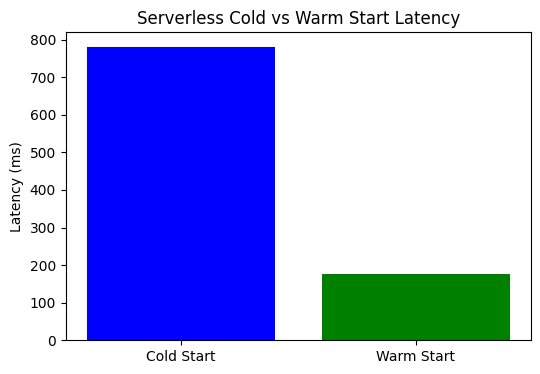

In [ ]:
import matplotlib.pyplot as plt

labels = ['Cold Start', 'Warm Start']
latencies = [cold_start_result['latency_ms'], warm_start_result['latency_ms']]

plt.figure(figsize=(6, 4))
plt.bar(labels, latencies, color=['blue', 'green'])
plt.title('Serverless Cold vs Warm Start Latency')
plt.ylabel('Latency (ms)')
plt.show()


In [ ]:
# Cost estimation for Google Cloud Functions
# Updated May 2025 pricing assumptions

requests_per_month = 1000000  # Example: 1 million requests
avg_execution_time_s = 1.0  # Assume 1 second per request
memory_gb = 2  # 2 GiB memory configured
cpu_vcpu = 1  # 1 vCPU (your function used 1 or 2 CPUs earlier)

# Pricing (as per Google documentation)
free_requests = 2000000  # 2M requests free per month
free_gb_s = 400000  # 400,000 GB-seconds free per month
free_cpu_s = 200000  # 200,000 vCPU-seconds free per month

# Paid rates (updated):
price_per_million_requests = 0.40  # $0.40 per 1M requests
price_per_gb_s = 0.0000025  # $0.0000025 per GB-second
price_per_cpu_s = 0.0000100  # $0.0000100 per vCPU-second

# Total compute usage
total_gb_s = requests_per_month * avg_execution_time_s * memory_gb
total_cpu_s = requests_per_month * avg_execution_time_s * cpu_vcpu

# Billable (after free tier)
billable_gb_s = max(0, total_gb_s - free_gb_s)
billable_cpu_s = max(0, total_cpu_s - free_cpu_s)
billable_requests = max(0, requests_per_month - free_requests)

# Cost calculations
cost_requests = (billable_requests / 1_000_000) * price_per_million_requests
cost_memory = billable_gb_s * price_per_gb_s
cost_cpu = billable_cpu_s * price_per_cpu_s

total_estimated_cost = cost_requests + cost_memory + cost_cpu

# Print
print("Cloud Function Cost Estimation (Monthly):")
print(f"- Total Requests: {requests_per_month}")
print(f"- Avg Execution Time: {avg_execution_time_s} seconds")
print(f"- Memory: {memory_gb} GB")
print(f"- CPU: {cpu_vcpu} vCPUs")
print("\nCost Breakdown:")
print(f"- Requests Cost: ${cost_requests:.4f}")
print(f"- Memory Cost: ${cost_memory:.4f}")
print(f"- CPU Cost: ${cost_cpu:.4f}")
print(f"\n✅ Estimated Total Monthly Cost: ${total_estimated_cost:.4f}")


Cloud Function Cost Estimation (Monthly):
- Total Requests: 1000000
- Avg Execution Time: 1.0 seconds
- Memory: 2 GB
- CPU: 1 vCPUs

Cost Breakdown:
- Requests Cost: $0.0000
- Memory Cost: $4.0000
- CPU Cost: $8.0000

✅ Estimated Total Monthly Cost: $12.0000
